In [1]:
import sys
sys.path.append('/host/d/Github')

import argparse
import os
import sys
import subprocess
import nibabel as nb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import Diffusion_denoising_thin_slice.Build_lists.Build_list as Build_list
import Diffusion_denoising_thin_slice.functions_collection as ff
import Diffusion_denoising_thin_slice.Data_processing as Data_processing

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# find clean images
# data_sheet = os.path.join('/mnt/camca_NAS/denoising/Patient_lists/fixedCT_static_simulation_train_test_gaussian.xlsx')
data_sheet = os.path.join('/host/d/Data/low_dose_CT/Patient_lists/mayo_low_dose_CT_gaussian_simulation_v1.xlsx')
b = Build_list.Build(data_sheet)
# batch_list, patient_id_list, patient_subid_list, random_num_list, noise_file_list, x0_list = b.__build__(batch_list = [0,1,2,3])  #x0 is motino-free, condition is motion-corrupted
# n = ff.get_X_numbers_in_interval(total_number = x0_list.shape[0],start_number = 0,end_number = 1, interval = 3)

batch_list, patient_id_list, random_num_list, noise_file_odd_list, noise_file_even_list, ground_truth_file_list, slice_num_list = b.__build__(batch_list = ['train','val','test'])

# randomly pick 30 numbers in n
# np.random.seed()
# np.random.shuffle(n)
# n = n[:20]

# x0_list = x0_list[n]
x0_list = ground_truth_file_list
print(x0_list)



['/host/d/Data/low_dose_CT/nii_imgs/L333/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L096/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L286/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L067/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L310/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L109/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L506/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L192/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L143/img.nii.gz'
 '/host/d/Data/low_dose_CT/nii_imgs/L291/img.nii.gz']


Text(0.5, 1.0, 'Histogram of Clean Images Before Equalization')

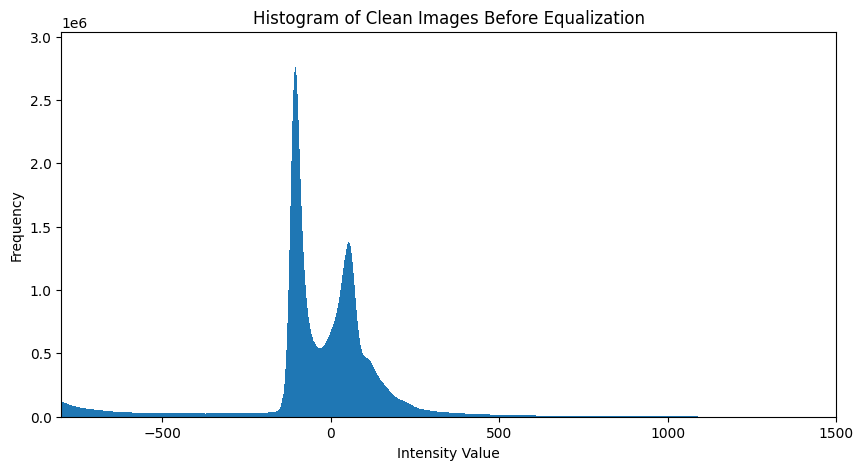

In [ ]:
# build the original histogram
transfer_max = 1500
transfer_min = -800
transfer_weight = 0.5
hist = np.zeros(transfer_max - transfer_min + 1, int)
for img in x0_list:
    img_np = nb.load(img).get_fdata()
    hist += np.histogram(img_np, bins=np.arange(transfer_min, transfer_max + 2))[0]


In [4]:
# equalize the histogram
print('Equalizing histogram...', flush=True)
bins = np.arange(-800, 1500 + 1)
bins_mapped = Data_processing.equalize_histogram(bins, hist, transfer_weight)

Equalizing histogram...


In [5]:
# save_bins
np.save('/host/d/Github/Diffusion_denoising_thin_slice/help_data/histogram_equalization/bins_lowdoseCT.npy', bins)
np.save('/host/d/Github/Diffusion_denoising_thin_slice/help_data/histogram_equalization/bins_mapped_lowdoseCT.npy', bins_mapped)

# or load
# bins = np.load('/host/d/Github/Diffusion_denoising_thin_slice/help_data/histogram_equalization/bins_lowdoseCT.npy')
# bins_mapped = np.load('/host/d/Github/Diffusion_denoising_thin_slice/help_data/histogram_equalization/bins_mapped_lowdoseCT.npy')

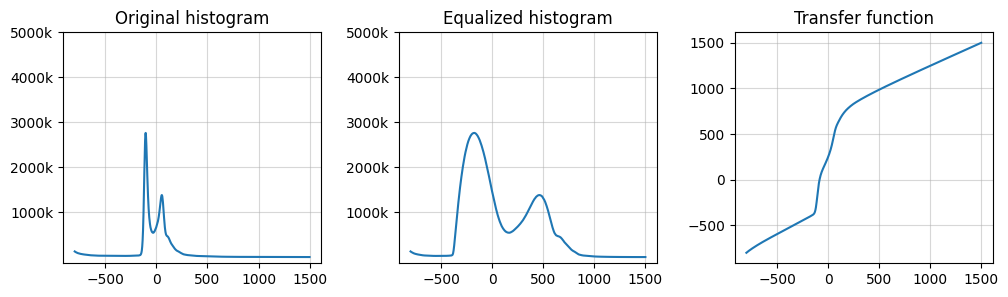

In [7]:
plt.figure(figsize=[12, 3])
plt.subplot(131)
plt.plot(bins, hist)
plt.title('Original histogram')
plt.grid(True, alpha=0.5)  # Set grid on with transparency
plt.yticks([100000 *10,200000*10,300000*10, 400000*10, 500000*10], ['1000k','2000k','3000k','4000k','5000k'])
# plt.xlabel('pixel values (HU)')
# plt.ylabel('pixel counts')

plt.subplot(132)
plt.plot(bins_mapped, hist)
plt.title('Equalized histogram')
plt.grid(True, alpha=0.5)  # Set grid on with transparency
plt.yticks([100000*10,200000*10,300000*10, 400000*10, 500000*10], ['1000k','2000k','3000k','4000k','5000k'])
# plt.xlabel('pixel values (HU)')
# plt.ylabel('pixel counts')

plt.subplot(133)
plt.plot(bins, bins_mapped)
plt.title('Transfer function')
plt.grid(True, alpha=0.5)  # Set grid on with transparency
# plt.xlabel('original pixel values (HU)')
# plt.ylabel('transfered pixel values (HU)')

plt.subplots_adjust(wspace=0.3)  # Set the gap width between subplots to 0.5

# plt.savefig('/mnt/camca_NAS/diffusion_ct_motion/pictures/Manuscript/histogram_equalization.pdf')
# 

In [8]:
img_test = nb.load(x0_list[0]).get_fdata()
img_test_mapped = Data_processing.apply_transfer_to_img(img_test, bins, bins_mapped)
img_test_normalized = Data_processing.normalize_image(img_test_mapped, normalize_factor = 1000, image_max = None, image_min = -500,invert = False)
img_test_normalized_back = Data_processing.normalize_image(img_test_normalized, normalize_factor = 1000, image_max = None, image_min = -500,invert = True)
img_test_mapped_reverse = Data_processing.apply_transfer_to_img(img_test_normalized_back, bins, bins_mapped, reverse=True)


Reverse error: 7.721219353501225e-06


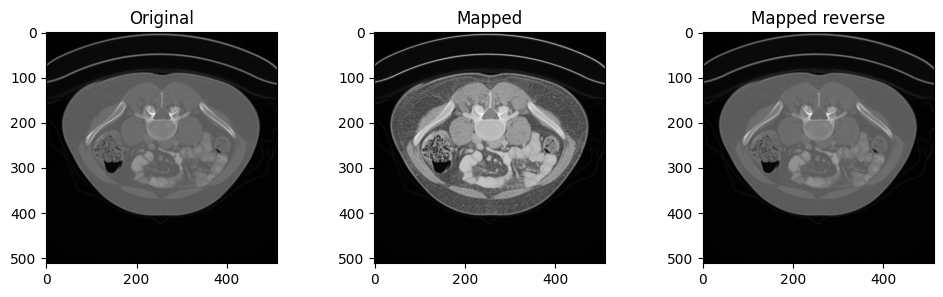

In [9]:
plt.figure(figsize=[12, 3])
plt.subplot(131)
# equal axis
plt.imshow(img_test[:,:,img_test.shape[-1] // 2].T, 'gray')
plt.title('Original')
plt.subplot(132)
plt.imshow(img_test_mapped[:,:,img_test_mapped.shape[-1] // 2].T, 'gray')
plt.title('Mapped')
plt.subplot(133)
plt.imshow(img_test_mapped_reverse[:,:,img_test_mapped_reverse.shape[-1] // 2].T, 'gray')
plt.title('Mapped reverse')

print('Reverse error:', np.mean(np.abs(img_test - img_test_mapped_reverse)), flush=True)

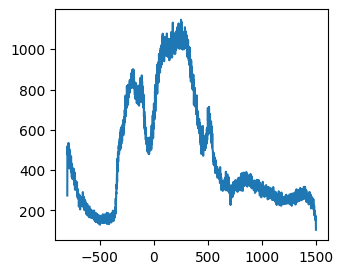

In [14]:
hist  = np.histogram(img_test_mapped, bins=np.arange(-800, 1500 + 2))[0]
plt.figure(figsize=[12, 3])
plt.subplot(131)
plt.plot(bins, hist)

hist = np.histogram(, bins=np.arange(transfer_min, transfer_max + 2))[0]